In [1]:
%cd /home/zsongah/tVAE_across_task_rat25_v2 
import torch
from configs.config import get_config
from data.dataset import Dataset
from runners.stVAE_runner import stVAE_runner
from scipy import stats
from evaluations.eval_utils import align_latent_mu
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

/home/zsongah/.conda/envs/transformer/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/zsongah/tVAE_across_task_rat25_v2


In [2]:
# settings
model_names = ['stVAE'] # model folder
experiment_names = ['stVAE'] # experiment name
rat = '025'
latent_dim = 6
task_1mc = '1MC'
task_2mc = '2MC'
day_1mc = '2020-07-16'
day_2mc = '2020-10-05'
test_fold = 0  
# load model from 1MC
load_file_prefix = f'{rat}_{task_1mc}_{day_1mc}_{test_fold}fold_' \
                f'{latent_dim}latent_' 
model_files = [f'results/{model_name}/{load_file_prefix}{experiment_name}.pth' for 
               model_name, experiment_name in zip(model_names, experiment_names)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# get model results
tasks = [task_1mc, task_2mc]
days = [day_1mc, day_2mc]
model_results = {name: {} for name in model_names}
for model_file, model_name in zip(model_files, model_names):
    config_file = model_name
    checkpoint = torch.load(model_file,map_location=device)
    for day, task in zip(days, tasks):
        config = get_config(config_file, [
                'DATA.RAT', rat,
                'DATA.TASK', task,
                'DATA.DAY', day, # can not use number_number 
                'DATA.TEST_FOLD', test_fold,
                'MODEL.LATENT_DIM', latent_dim,
            ])
        dataset = Dataset(config, rat, day, task, test_fold, device)
        if model_name == 'stVAE':
            runner = stVAE_runner(config, dataset, model_name) 
        runner.model.load_state_dict(checkpoint['model_state_dict'])
        runner.model.eval()
        result_test = runner.evaluate()
        result_train = runner.eval_train()
        model_results[model_name][task] = {
            'result_test': result_test,
            'result_train': result_train
        }

/tmp/ipykernel_52735/1427005433.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file,map_location=device)


| load neural data | train length: 8121, trial: 108 | test length: 2433 , trial: 26 | 32 total neurons | 16 M1 neurons | 
| load neural data | train length: 13438, trial: 141 | test length: 3814 , trial: 35 | 32 total neurons | 16 M1 neurons | 


In [3]:
scaled_latent_state ={model:{} for model in model_names}
for model_name in model_names:
     for task in tasks:
        latent_mu = stats.zscore(model_results[model_name][task]['result_train']['latent_mu'],axis=0)
        actions = model_results[model_name][task]['result_train']['actions']
        scaled_latent_state[model_name][task], len_start, len_press, len_release, len_after_release, trial_types = align_latent_mu(actions, latent_mu)
        
cue_start = len_start-1
press_lever = len_start + len_press - 1
release_lever = len_start + len_press + len_release - 1
trial_num, trial_length, feature_num = scaled_latent_state['stVAE']['2MC'].shape
start_point = cue_start
end_point = press_lever

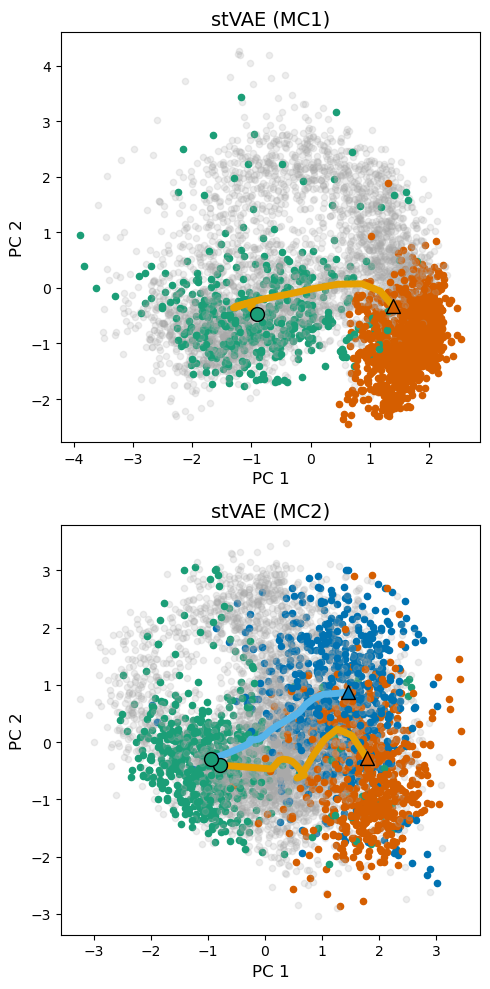

In [ ]:
COLOR_HIGH_LEVER = '#D55E00'  # 深橙色，高杠杆
COLOR_LOW_LEVER = '#0072B2'  # 海蓝色，低杠杆
COLOR_REST = '#1B9E77'  # 翡翠绿
COLOR_OTHER = '#A9A9A9'  # 灰色
COLOR_HIGH_LEVER_TRAJ = '#E69F00'  # 橙色，高杠杆轨迹（稍微浅一些）
COLOR_LOW_LEVER_TRAJ = '#56B4E9'   # 浅蓝色，低杠杆轨迹

def plot_MC1_PCA_for_model(scaled_latent, title, ax):
    """
    对 MC1 (1MC) 数据进行 PCA 分解后绘图，
    scaled_latent: shape 为 (trial_num, trial_length, latent_dim)
    返回 PCA 对象、降维后的所有试次数据以及 averaged trial（均值轨迹）
    """
    # 将数据拉平成二维：(trial_num * trial_length, latent_dim)
    latent_flat = np.reshape(scaled_latent, (-1, scaled_latent.shape[-1]))
    pca = PCA(n_components=2)
    latent_pca_flat = pca.fit_transform(latent_flat)
    # 恢复回 (trial_num, trial_length, 2)
    latent_pca = latent_pca_flat.reshape(scaled_latent.shape[0], scaled_latent.shape[1], -1)
    
    # 计算 averaged trial （对所有 trial 在时间维度取均值）
    averaged_trial = np.mean(latent_pca, axis=0)
    
    # 对每个 trial 绘图
    for i in range(latent_pca.shape[0]):
        trial_data = latent_pca[i]
        # 绘制 “Other” 区间：由 cue_start 到 press_lever，以及 release_lever 之后
        other_points = np.vstack(( trial_data[cue_start:press_lever], trial_data[release_lever:] ))
        ax.scatter(other_points[:, 0], other_points[:, 1], c=COLOR_OTHER, s=20, alpha=0.2, 
                   label='Other' if i == 0 else '')
        # 绘制 “Rest” 部分：从 trial 开始至 cue_start
        rest_points = trial_data[:cue_start]
        ax.scatter(rest_points[:, 0], rest_points[:, 1], c=COLOR_REST, s=20, alpha=1, 
                   label='Rest' if i == 0 else '')
        # 绘制 “Press Lever” 部分：从 press_lever 到 release_lever（高杠杆）
        press_points = trial_data[press_lever:release_lever]
        ax.scatter(press_points[:, 0], press_points[:, 1], c=COLOR_HIGH_LEVER, s=20, alpha=1, 
                   label='High Lever' if i == 0 else '')
    
    # 绘制 averaged trial 的轨迹线（高杠杆轨迹）
    ax.plot(averaged_trial[start_point:end_point+1, 0], averaged_trial[start_point:end_point+1, 1],
            c=COLOR_HIGH_LEVER_TRAJ, linewidth=5, label='Averaged High Trial')
    # 标记 averaged trial 的起点和终点
    ax.scatter(averaged_trial[cue_start, 0], averaged_trial[cue_start, 1],
               c=COLOR_REST, s=100, marker='o', edgecolors='black', zorder=5, label='Start Point')
    ax.scatter(averaged_trial[press_lever, 0], averaged_trial[press_lever, 1],
               c=COLOR_HIGH_LEVER, s=100, marker='^', edgecolors='black', zorder=5, label='End Point')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('PC 1', fontsize=12)
    ax.set_ylabel('PC 2', fontsize=12)
    
    return pca, latent_pca, averaged_trial

def plot_MC2_in_MC1_PCA(scaled_latent, trial_types, title, ax, pca):
    """
    将 MC2 (2MC) 数据映射到 MC1 得到的 PCA 平面上绘图
    scaled_latent: MC2 数据，shape 同样为 (trial_num, trial_length, latent_dim)
    trial_types: 每个 trial 对应的类型（例如：1 表示 high、-1 表示 low）
    """
    latent_flat = np.reshape(scaled_latent, (-1, scaled_latent.shape[-1]))
    latent_pca_flat = pca.transform(latent_flat)
    latent_pca = latent_pca_flat.reshape(scaled_latent.shape[0], scaled_latent.shape[1], -1)
    
    # 分离 high trial 和 low trial（注意：trial_types 是一维数组，每个 trial 对应一个标签）
    high_indices = np.array(trial_types) == 1
    low_indices = np.array(trial_types) == -1
    averaged_high  = np.mean(latent_pca[high_indices.flatten()], axis=0)
    averaged_low   = np.mean(latent_pca[low_indices.flatten()], axis=0)
    
    # 绘制每个 trial 的点
    for i in range(latent_pca.shape[0]):
        trial_data = latent_pca[i]
        this_type = trial_types[i]
        # 绘制 “Other” 点
        other_points = np.vstack((trial_data[cue_start:press_lever], trial_data[release_lever:]))
        ax.scatter(other_points[:, 0], other_points[:, 1], c=COLOR_OTHER, s=20, alpha=0.2)
        # 绘制 “Rest” 点
        rest_points = trial_data[:cue_start]
        ax.scatter(rest_points[:, 0], rest_points[:, 1], c=COLOR_REST, s=20, alpha=1)
        # 绘制 “Press Lever” 点，根据 trial 类型着色
        press_points = trial_data[press_lever:release_lever]
        if this_type == 1:
            ax.scatter(press_points[:, 0], press_points[:, 1], c=COLOR_HIGH_LEVER, s=20, alpha=1)
        elif this_type == -1:
            ax.scatter(press_points[:, 0], press_points[:, 1], c=COLOR_LOW_LEVER, s=20, alpha=1)
    
    # 绘制 averaged high trial 的轨迹线
    ax.plot(averaged_high[start_point:end_point+1, 0], averaged_high[start_point:end_point+1, 1],
            c=COLOR_HIGH_LEVER_TRAJ, linewidth=5)
    ax.scatter(averaged_high[cue_start, 0], averaged_high[cue_start, 1],
               c=COLOR_REST, s=100, marker='o', edgecolors='black', zorder=5)
    ax.scatter(averaged_high[press_lever, 0], averaged_high[press_lever, 1],
               c=COLOR_HIGH_LEVER, s=100, marker='^', edgecolors='black', zorder=5)
    
    # 绘制 averaged low trial 的轨迹线
    ax.plot(averaged_low[start_point:end_point+1, 0], averaged_low[start_point:end_point+1, 1],
            c=COLOR_LOW_LEVER_TRAJ, linewidth=5)
    ax.scatter(averaged_low[cue_start, 0], averaged_low[cue_start, 1],
               c=COLOR_REST, s=100, marker='o', edgecolors='black', zorder=5)
    ax.scatter(averaged_low[press_lever, 0], averaged_low[press_lever, 1],
               c=COLOR_LOW_LEVER, s=100, marker='^', edgecolors='black', zorder=5)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('PC 1', fontsize=12)
    ax.set_ylabel('PC 2', fontsize=12)
    
    return latent_pca

# =============================================================================
# 生成2行n列 (n=模型个数) 的图
# 第一行绘制 MC1 数据的 PCA ，第二行绘制 MC2 数据在该 PCA 平面中的投影
# =============================================================================

n_models = len(model_names)

# 创建子图：2行，每个模型一列
fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 10))

for i, model_name in enumerate(model_names):
    # 使用该模型 1MC 与 2MC 下的对齐后数据
    latent_MC1 = scaled_latent_state[model_name]['1MC']
    latent_MC2 = scaled_latent_state[model_name]['2MC']
    
    # 第一行：MC1 数据进行 PCA 得到 2D 表示
    if n_models > 1:
        ax1 = axes[0, i]
    else:
        ax1 = axes[0]
    title1 = f"{model_name} (MC1)"
    pca, latent_MC1_pca, avg_MC1 = plot_MC1_PCA_for_model(latent_MC1, title1, ax1)
    
    # 第二行：MC2 数据映射到 MC1 的 PCA 平面上
    if n_models > 1:
        ax2 = axes[1, i]
    else:
        ax2 = axes[1]
    title2 = f"{model_name} (MC2)"
    plot_MC2_in_MC1_PCA(latent_MC2, trial_types, title2, ax2, pca)

plt.tight_layout()
plt.show()